In [96]:
# Jump-Start for the Bank Marketing Study... Solution Code

# Case described in Marketing Data Science: Modeling Techniques
# for Predictive Analytics with R and Python (Miller 2015)

# jump-start code revised by Thomas W. Milller (2018/10/07)

# Scikit Learn documentation for this assignment:
# http://scikit-learn.org/stable/auto_examples/classification/
#   plot_classifier_comparison.html
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score
# http://scikit-learn.org/stable/modules/generated/
#   sklearn.linear_model.LogisticRegression.html
# http://scikit-learn.org/stable/modules/model_evaluation.html 
# http://scikit-learn.org/stable/modules/generated/
#  sklearn.model_selection.KFold.html

# prepare for Python version 3x features and functions
# comment out for Python 3.x execution
# from __future__ import division, print_function
# from future_builtins import ascii, filter, hex, map, oct, zip

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')  # start with smaller data set
# examine the shape of original input data
print(bank.shape)

# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
print(bank.shape)

# look at the list of column names, note that y is the response
list(bank.columns.values)

# look at the beginning of the DataFrame
print(bank.head())

# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

# gather three explanatory variables and response into a numpy array 
# here we use .T to obtain the transpose for the structure we want
model_data = np.array([np.array(default), np.array(housing), np.array(loan), 
    np.array(response)]).T

# examine the shape of model_data, which we will use in subsequent modeling
print(model_data.shape)

(4521, 17)
(4521, 17)
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome response  
0  cellular   19   oct        79         1     -1         0  unknown       no  
1  cellular   11   may       220         1    339         4  failure       no  
2  cellular   16   apr       185         1    330         1  failure       no  
3   unknown    3   jun       199         4     -1         0  unknown       no  
4   unknown    5   may       226         1     -1         0  unknown       no  
(4521, 4)


In [97]:
# cross-validation scoring code adapted from Scikit Learn documentation
from sklearn.metrics import roc_auc_score

# specify the set of classifiers being evaluated
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
names = ["Naive_Bayes", "Logistic_Regression"]
classifiers = [BernoulliNB(alpha=1.0, binarize=0.5, 
                           class_prior = [0.5, 0.5], fit_prior=False), 
               LogisticRegression()]

# dimensions of the additive model X input and y response
print('\nData dimensions:', model_data.shape)


Data dimensions: (4521, 4)


In [98]:
# --------------------------------------------------------
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

# ten-fold cross-validation employed here
N_FOLDS = 10

# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)
# check the splitting process by looking at fold observation counts
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
#   note that 0:model_data.shape[1]-1 slices for explanatory variables
#   and model_data.shape[1]-1 is the index for the response variable    
    X_train = model_data[train_index, 0:model_data.shape[1]-1]
    X_test = model_data[test_index, 0:model_data.shape[1]-1]
    y_train = model_data[train_index, model_data.shape[1]-1]
    y_test = model_data[test_index, model_data.shape[1]-1]   
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)

    index_for_method = 0  # initialize
    for name, clf in zip(names, classifiers):
        print('\nClassifier evaluation for:', name)
        print('  Scikit Learn method:', clf)
        clf.fit(X_train, y_train)  # fit on the train set for this fold
        # evaluate on the test set for this fold
        y_test_predict = clf.predict_proba(X_test)
        fold_method_result = roc_auc_score(y_test, y_test_predict[:,1]) 
        print('Area under ROC curve:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      '\nMethod                 Area under ROC Curve', sep = '')     
print(cv_results_df.mean())   


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4068, 3)
X_test: (453, 3)
y_train: (4068,)
y_test: (453,)

Classifier evaluation for: Naive_Bayes
  Scikit Learn method: BernoulliNB(alpha=1.0, binarize=0.5, class_prior=[0.5, 0.5], fit_prior=False)
Area under ROC curve: 0.5878522062732588

Classifier evaluation for: Logistic_Regression
  Scikit Learn method: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Area under ROC curve: 0.5878522062732588

Fold index: 1 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (4069, 3)
X_test: (452, 3)
y_train: (4069,)
y_test: (452,)

Classifier evaluation for: Naive_Bayes
  S

In [118]:
# --------------------------------------------------------
# Select method and apply to specific test cases
# --------------------------------------------------------
my_default = np.array([1, 1, 1, 1, 0, 0, 0, 0], np.int32)
my_housing = np.array([1, 1, 0, 0, 1, 1, 0, 0], np.int32)
my_loan = np.array([1, 0, 1, 0, 1, 0, 1, 0], np.int32)

my_X_test = np.vstack([my_default, my_housing, my_loan]).T

# fit logistic regression to full data set
clf = LogisticRegression()
X_train = model_data[:, 0:model_data.shape[1]-1]
y_train = model_data[:, model_data.shape[1]-1]
clf.fit(X_train, y_train)

# predict specific test cases
y_my_test_predict = clf.predict_proba(my_X_test)

# create DataFrame for displaying test cases and predicted probabilities
my_targeting_df = pd.DataFrame(np.hstack([my_X_test, y_my_test_predict]))
my_targeting_df.columns = ['default', 'housing', 'loan', 
                           'predict_NO', 'predict_YES']
print('\n\nLogistic regression model predictions for test cases:')
print(my_targeting_df) 

# for targeting, select group(s) with highest predictie probabiliy 
# of responding to the promotional mailers



Logistic regression model predictions for test cases:
   default  housing  loan  predict_NO  predict_YES
0      1.0      1.0   1.0    0.945729     0.054271
1      1.0      1.0   0.0    0.892349     0.107651
2      1.0      0.0   1.0    0.900786     0.099214
3      1.0      0.0   0.0    0.811988     0.188012
4      0.0      1.0   1.0    0.953277     0.046723
5      0.0      1.0   0.0    0.906588     0.093412
6      0.0      0.0   1.0    0.914016     0.085984
7      0.0      0.0   0.0    0.834890     0.165110


In [100]:
# Additional Code:
bank['response'].value_counts()

no     4000
yes     521
Name: response, dtype: int64

In [101]:
#print(521/4521)
count_no_sub = len(bank[bank['response']=='no'])
count_sub =  len(bank[bank['response']=='yes'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 88.47600088476001
percentage of subscription 11.523999115239992


In [102]:
bank.groupby('response').mean()

,age,balance,day,duration,campaign,pdays,previous
response,,,,,,,
no,40.998000,1403.211750,15.948750,226.347500,2.862250,36.006000,0.471250
yes,42.491363,1571.955854,15.658349,552.742802,2.266795,68.639155,1.090211


In [103]:
bank.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.682008,1226.736402,16.324268,234.669456,2.631799,49.993724,0.644351
blue-collar,40.156448,1085.161734,15.482030,278.161734,2.846723,41.590909,0.493658
entrepreneur,42.011905,1645.125000,15.255952,285.476190,2.589286,32.273810,0.428571
housemaid,47.339286,2083.803571,15.294643,292.633929,2.500000,26.401786,0.357143
management,40.540764,1766.928793,16.254902,260.536636,2.973168,40.968008,0.549020
retired,61.869565,2319.191304,15.556522,285.656522,2.465217,35.073913,0.591304
self-employed,41.453552,1392.409836,16.180328,264.125683,3.278689,28.256831,0.590164
services,38.570743,1103.956835,15.515588,262.486811,2.822542,36.371703,0.443645
student,26.821429,1543.821429,16.392857,248.690476,2.392857,45.714286,0.964286


In [104]:
bank.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.475379,1122.390152,15.753788,279.232955,2.604167,38.827652,0.439394
married,43.454415,1463.195567,15.905971,256.528781,2.847336,38.466929,0.519128
single,33.927258,1460.414716,16.008361,274.601171,2.751672,43.220736,0.642977


In [105]:
bank.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,46.833333,1411.544248,15.505900,261.709440,2.865782,35.069322,0.460177
secondary,40.062446,1196.814397,15.977884,269.863833,2.734172,40.934085,0.528621
tertiary,39.645926,1775.423704,16.009630,256.881481,2.901481,39.824444,0.612593
unknown,45.299465,1701.245989,15.946524,250.449198,2.486631,41.983957,0.508021


In [106]:
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score
# predict specific test cases
y_train_pred = clf.predict(X_train)
print ('confusion_matrix:\n ',confusion_matrix(y_train, y_train_pred))
print ('precision_score: ', precision_score(y_train, y_train_pred))
print ('recall_score: ',recall_score(y_train, y_train_pred))
print ('f1_score: ',f1_score(y_train, y_train_pred))


confusion_matrix:
  [[4000    0]
 [ 521    0]]
precision_score:  0.0
recall_score:  0.0
f1_score:  0.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
from sklearn.model_selection import cross_val_score,cross_val_predict
print ('Cross-Validation Accuracy: ', cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy"))

y_train_pred = cross_val_predict(clf, X_train, y_train, cv=10)
print ('\nCross-Validation confusion_matrix:')
confusion_matrix(y_train, y_train_pred)
#4000 True Negative and 521 false postive

Cross-Validation Accuracy:  [0.88300221 0.88495575 0.88495575 0.88495575 0.88495575 0.88495575
 0.88495575 0.88495575 0.88495575 0.88495575]

Cross-Validation confusion_matrix:


array([[4000,    0],
       [ 521,    0]], dtype=int64)

In [108]:
y_scores = cross_val_predict(clf, X_train, y_train, cv=10, method="decision_function")

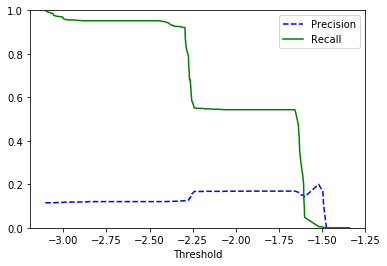

In [115]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
import matplotlib.pyplot as plt
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
 plt.xlabel("Threshold")
 plt.legend(loc="upper right")
 plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


Text(0,0.5,'Precisions')

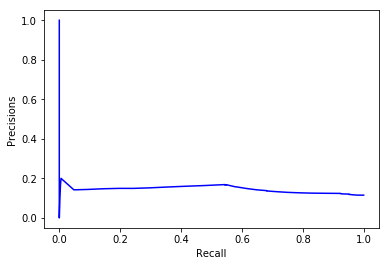

In [110]:
plt.plot(recalls, precisions, "b-")
plt.xlabel("Recall")
plt.ylabel("Precisions")

In [120]:
y_train_pred_10 = (y_scores > -2.26)
print ('precision_score: ',precision_score(y_train, y_train_pred_10))
print ('recall_score: ',recall_score(y_train, y_train_pred_10))
print ('f1_score: ',f1_score(y_train, y_train_pred_10))

precision_score:  0.1486111111111111
recall_score:  0.6161228406909789
f1_score:  0.2394628869824692


In [112]:
confusion_matrix(y_train, y_train_pred_10)

array([[2161, 1839],
       [ 200,  321]], dtype=int64)

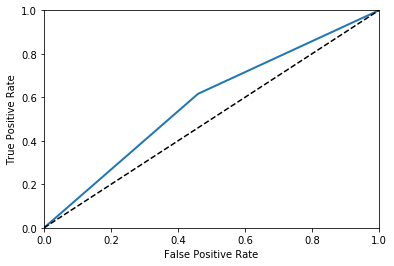

In [113]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_10)
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--')
 plt.axis([0, 1, 0, 1])
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)

In [114]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred_10)

0.5781864203454895